In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

# Task 1

### Testing

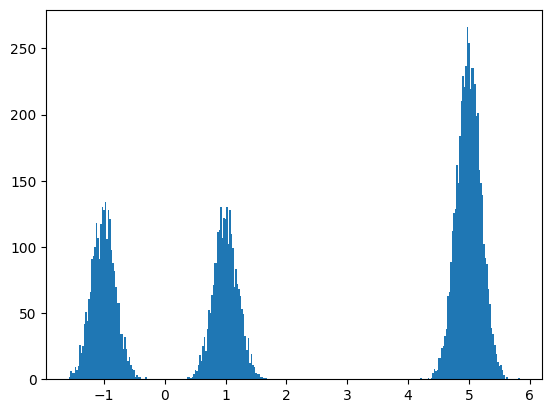

In [72]:
choice_of_gaussian = np.random.choice(3, 10000, p=[0.25, 0.25, 0.5])

zeros = np.zeros(10000)
zeros[choice_of_gaussian == 0] = np.random.normal(-1, 0.2, sum(choice_of_gaussian == 0))
zeros[choice_of_gaussian == 1] = np.random.normal(1, 0.2, sum(choice_of_gaussian == 1))
zeros[choice_of_gaussian == 2] = np.random.normal(5, 0.2, sum(choice_of_gaussian == 2))

plt.hist(zeros, bins=300)
plt.show()

In [63]:
# generate 9 features of 1000 samples form normal distribution
X = np.random.normal(0, 1, (1000, 9))
print(X.shape)

(1000, 9)


In [74]:
y = np.random.choice(2, 10000, p=[0.9, 0.1])

y[zeros > 3] = np.random.choice(2, sum(zeros > 3), p=[0.1, 0.9])

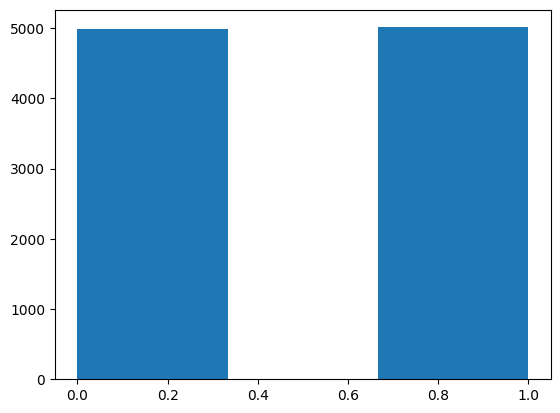

In [78]:
plt.hist(y, bins=3)
plt.show()

(array([ 496.,    0., 4509.]),
 array([0.        , 0.33333333, 0.66666667, 1.        ]),
 <BarContainer object of 3 artists>)

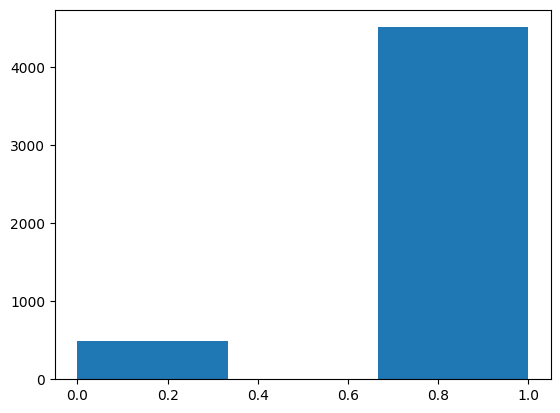

In [80]:
plt.hist(y[zeros > 3], bins=3)
plt.show()

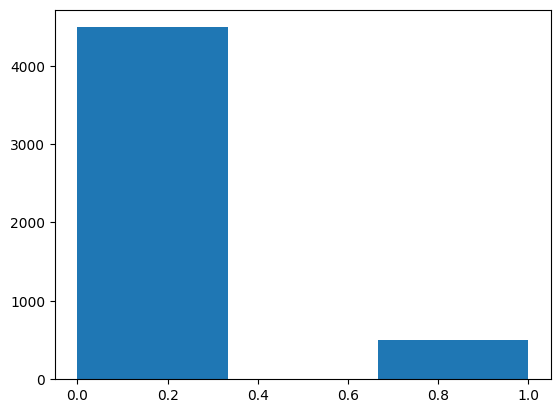

In [81]:
plt.hist(y[zeros < 3], bins=3)
plt.show()

### Function to generate

In [82]:
def generate_data(num_data=1000):
    choice_of_gaussian = np.random.choice(3, num_data, p=[0.25, 0.25, 0.5])

    first_feature = np.zeros(num_data)
    first_feature[choice_of_gaussian == 0] = np.random.normal(
        -1, 0.2, sum(choice_of_gaussian == 0)
    )

    first_feature[choice_of_gaussian == 1] = np.random.normal(
        1, 0.2, sum(choice_of_gaussian == 1)
    )

    first_feature[choice_of_gaussian == 2] = np.random.normal(
        5, 0.2, sum(choice_of_gaussian == 2)
    )

    other_features = np.random.normal(0, 1, (num_data, 9))

    X = np.column_stack((first_feature, other_features))

    y = np.random.choice(2, num_data, p=[0.9, 0.1])

    y[first_feature > 3] = np.random.choice(2, sum(first_feature > 3), p=[0.1, 0.9])

    return X, y

In [83]:
X, y = generate_data(10000)

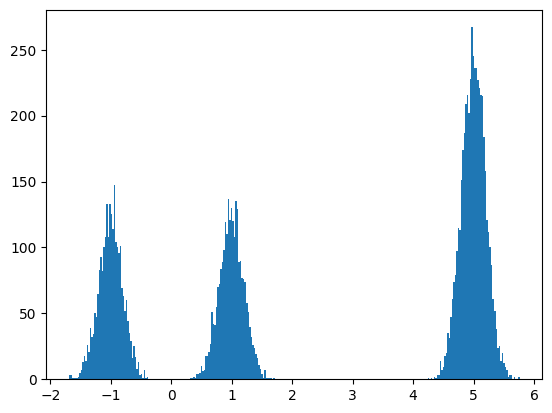

In [84]:
plt.hist(X[:, 0], bins=300)
plt.show()

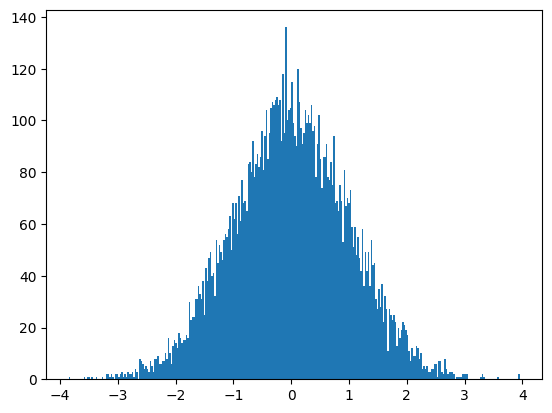

In [85]:
plt.hist(X[:, 2], bins=300)
plt.show()

### Generate test and train

In [86]:
X_train, y_train = generate_data(1000)
X_test, y_test = generate_data(1000)

# Task 2

In [ ]:
def stochastic_gradient_descent(
    X,
    y,
    initial_solution,
    calculate_gradient,
    learning_rate=0.01,
    max_num_epoch=1000,
    verbose=False,
):
    # initialization
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy().T
        if y.shape[0] == 1:
            y = y[0]
    current_solution = initial_solution

    for _ in range(max_num_epoch):
        N, _ = X.shape
        shuffled_idx = np.random.permutation(N)
        X, y = X[shuffled_idx], y[shuffled_idx]
        for X_selected, y_selected in zip(X, y):
            gradient = calculate_gradient(X_selected, y_selected, current_solution)
            current_solution = current_solution - learning_rate * gradient
        if verbose:
            print("Epoch:", current_solution)
    return current_solution


def calculate_gradient(X, y, w):
    # calculate the gradient
    gradient = -2 * X * (y - np.dot(X, w))

    return gradient


X = pd.DataFrame(np.array([[1, 2], [2, 3], [3, 4], [4, 5]]))
y = pd.DataFrame(np.array([3, 5, 7, 9]))
initial_solution = np.array([0, 0])
learning_rate = 0.01
max_num_epoch = 1000

solution = stochastic_gradient_descent(
    X, y, initial_solution, calculate_gradient, learning_rate, max_num_epoch
)
print("Solution:", solution)

# Task 3

In [89]:
mixture = X_train[:, 0]

## my own implementation of kde

In [97]:
class kde:
    __slots__ = ["kernel_type", "bandwidth", "data", "n"]

    def __init__(self, kernel_type="gaussian", bandwidth=1):
        self.kernel_type = kernel_type
        self.bandwidth = bandwidth

    def fit(self, data):
        self.data = data
        self.n = len(data)

    @abstractmethod
    def gaussian_kernel(self, x, mean, std):
        return np.exp(-0.5 * ((x - mean) / std) ** 2) / (std * np.sqrt(2 * np.pi))

    @abstractmethod
    def top_hat_kernel(self, x, mean, std):
        return (np.abs(x - mean) <= std) / (2 * std)

    @abstractmethod
    def epanechnikov_kernel(self, x, mean, std):
        return 3 / 4 * (1 - ((x - mean) / std) ** 2) * (np.abs(x - mean) <= std) / std

    @abstractmethod
    def exponential_kernel(self, x, mean, std):
        return np.exp(-np.abs(x - mean) / std) / (2 * std)

    def transform(self, x):
        if not isinstance(x, np.ndarray):
            x = np.array([x])
        solution = np.zeros(len(x))
        for data_point in self.data:
            if self.kernel_type == "gaussian":
                solution += self.gaussian_kernel(x, mean=data_point, std=self.bandwidth)
            elif self.kernel_type == "top_hat":
                solution += self.top_hat_kernel(x, mean=data_point, std=self.bandwidth)
            elif self.kernel_type == "epanechnikov":
                solution += self.epanechnikov_kernel(
                    x, mean=data_point, std=self.bandwidth
                )
            elif self.kernel_type == "exponential":
                solution += self.exponential_kernel(
                    x, mean=data_point, std=self.bandwidth
                )
            else:
                raise ValueError("Invalid kernel type")
        return solution / (self.n)

Text(0.5, 1.0, 'Kernel Density Estimation with Gaussian Kernel, real density and histogram')

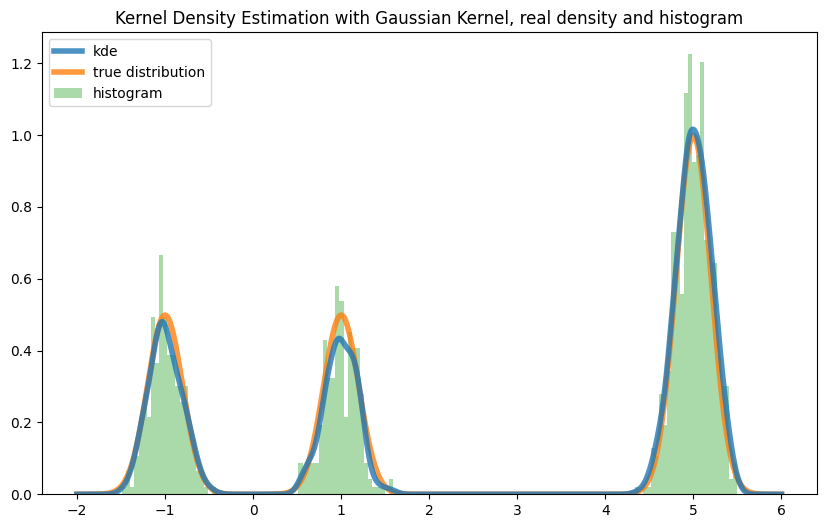

In [120]:
kd = kde(kernel_type="gaussian", bandwidth=0.07)

kd.fit(mixture)

plt.figure(figsize=(10, 6))
plt.plot(
    np.linspace(-2, 6, 5000),
    kd.transform(np.linspace(-2, 6, 5000)),
    label="kde",
    linewidth=4,
    alpha=0.8,
    zorder=10,
)
plt.plot(
    np.linspace(-2, 6, 5000),
    0.25
    * np.exp(-0.5 * ((np.linspace(-2, 6, 5000) - 1) / 0.2) ** 2)
    / (0.2 * np.sqrt(2 * np.pi))
    + 0.25
    * np.exp(-0.5 * ((np.linspace(-2, 6, 5000) + 1) / 0.2) ** 2)
    / (0.2 * np.sqrt(2 * np.pi))
    + 0.5
    * np.exp(-0.5 * ((np.linspace(-2, 6, 5000) - 5) / 0.2) ** 2)
    / (0.2 * np.sqrt(2 * np.pi)),
    label="true distribution",
    linewidth=4,
    alpha=0.8,
)
plt.hist(mixture, bins=150, alpha=0.4, density=True, label="histogram")
plt.legend()
plt.title("Kernel Density Estimation with Gaussian Kernel, real density and histogram")

We can substitute real density with density estimator and instead of integrating we can sum.

In [124]:
estimated_density = kd.transform(np.linspace(-2, 6, 5000))
estimated_entropy = -np.sum(estimated_density * np.log(estimated_density)) / 5000
print(f"Estimated entropy: {estimated_entropy}")

Estimated entropy: 0.10491041402374537


In [125]:
entropies = []
for _ in range(20):
    X_train, y_train = generate_data(1000)
    mixture = X_train[:, 0]
    kd = kde(kernel_type="gaussian", bandwidth=0.07)
    kd.fit(mixture)
    estimated_density = kd.transform(np.linspace(-2, 6, 5000))
    estimated_entropy = -np.sum(estimated_density * np.log(estimated_density)) / 5000
    entropies.append(estimated_entropy)

print(f"Mean estimated entropy: {np.mean(entropies)}")
print(f"Standard deviation of estimated entropy: {np.std(entropies)}")

Mean estimated entropy: 0.11170451916650959
Standard deviation of estimated entropy: 0.0032297702501015804


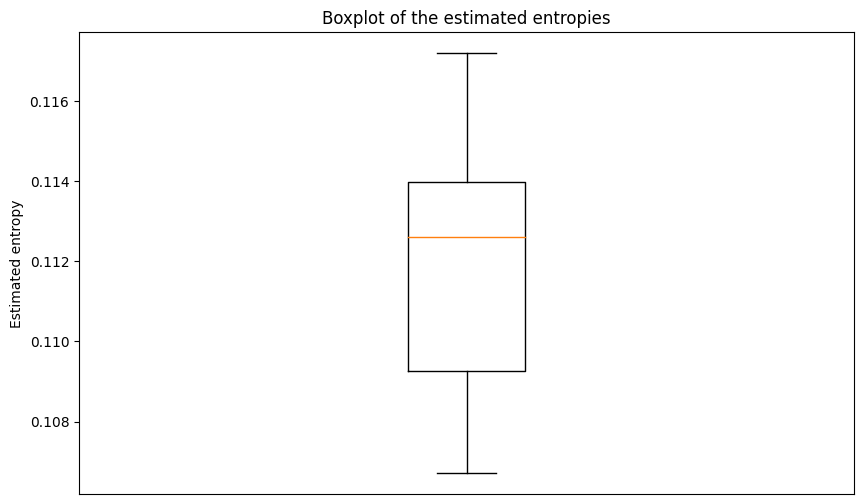

In [127]:
# boxplot of the estimated entropies
plt.figure(figsize=(10, 6))
plt.boxplot(entropies)
plt.title("Boxplot of the estimated entropies")
plt.ylabel("Estimated entropy")
plt.xticks([])
plt.show()